# Model Training and Comparison

1. Data preparation with your custom preprocessing pipeline
2. Model configuration with multiple algorithms
3. Cross-validation for robust performance estimates
4. Comprehensive comparison with multiple metrics
5. Visualizations including bar charts, radar charts, confusion matrices, and ROC curves
6. Feature importance analysis for interpretable models
7. Final summary with recommendations

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Import custom modules
import sys
sys.path.append('../src')
from data_preprocessing import DataLoader, create_pipeline
from models import ModelTrainer, BinaryClassifier, cross_validate_model
from evaluation import ClassificationEvaluator, compare_models, print_evaluation_summary

## Data Loading and Preprocessing

In [3]:
# Load and prepare the dataset
loader = DataLoader()
df = loader.load_sklearn_dataset("breast_cancer", save_raw=True)

# Create preprocessing pipeline
X_train, X_test, y_train, y_test, preprocessor = create_pipeline(
    df,
    target_column="target",
    handle_missing=True,
    encode_categorical=True,
    scale_features=True,
    test_size=0.2,
    random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Class distribution:\n{pd.Series(y_train).value_counts()}")

Dataset saved to C:\Users\nobu\PyCharmMiscProject\data\raw\breast_cancer.csv
Training set shape: (455, 30)
Test set shape: (114, 30)
Class distribution:
target
1    285
0    170
Name: count, dtype: int64


## Model Configuration and Training

In [4]:
# Define model configurations
model_configs = {
    "Random Forest": {
        "model_type": "random_forest",
        "n_estimators": 100,
        "max_depth": 10,
        "min_samples_split": 5
    },
    "Logistic Regression": {
        "model_type": "logistic_regression",
        "C": 1.0,
        "max_iter": 1000
    },
    "SVM": {
        "model_type": "svm",
        "C": 1.0,
        "kernel": "rbf",
        "probability": True
    },
    "Gradient Boosting": {
        "model_type": "gradient_boosting",
        "n_estimators": 100,
        "learning_rate": 0.1,
        "max_depth": 6
    },
    "Decision Tree": {
        "model_type": "decision_tree",
        "max_depth": 10,
        "min_samples_split": 5
    }
}

# Train all models
trainer = ModelTrainer(random_state=42)
trained_models = trainer.train_multiple_models(X_train, y_train, model_configs)

print("✅ All models trained successfully!")

Training Random Forest...
Training Logistic Regression...
Training SVM...
Training Gradient Boosting...
Training Decision Tree...
✅ All models trained successfully!


## Cross-Validation Analysis

In [5]:
# Perform cross-validation for each model
cv_results = {}

print("Performing cross-validation...")
for name, model in trained_models.items():
    cv_result = cross_validate_model(
        model, X_train, y_train, cv=5, scoring='accuracy'
    )
    cv_results[name] = cv_result
    print(f"{name:20s} - CV Score: {cv_result['mean_score']:.4f} (±{cv_result['std_score']:.4f})")

Performing cross-validation...
Random Forest        - CV Score: 0.9538 (±0.0254)
Logistic Regression  - CV Score: 0.9802 (±0.0128)
SVM                  - CV Score: 0.9714 (±0.0179)
Gradient Boosting    - CV Score: 0.9231 (±0.0139)
Decision Tree        - CV Score: 0.9253 (±0.0128)


## Model Evaluation and Comparison

In [6]:
# Compare all models on test set
comparison_df = compare_models(trained_models, X_test, y_test, average='weighted')

print("Model Comparison Results:")
print("=" * 80)
print(comparison_df.round(4))

Model Comparison Results:
                     accuracy  precision  recall  f1_score  matthews_corrcoef  \
Logistic Regression    0.9825     0.9825  0.9825    0.9825             0.9623   
SVM                    0.9825     0.9825  0.9825    0.9825             0.9623   
Random Forest          0.9474     0.9474  0.9474    0.9474             0.8869   
Decision Tree          0.9035     0.9090  0.9035    0.9045             0.8011   
Gradient Boosting      0.8947     0.9022  0.8947    0.8960             0.7851   

                     cohen_kappa  roc_auc  average_precision  log_loss  
Logistic Regression       0.9623   0.9954             0.9971    0.0777  
SVM                       0.9623   0.9950             0.9969    0.0860  
Random Forest             0.8869   0.9947             0.9969    0.1127  
Decision Tree             0.7977   0.9216             0.9283    2.8648  
Gradient Boosting         0.7803   0.9491             0.9519    0.7090  


## Detailed Performance Visualization

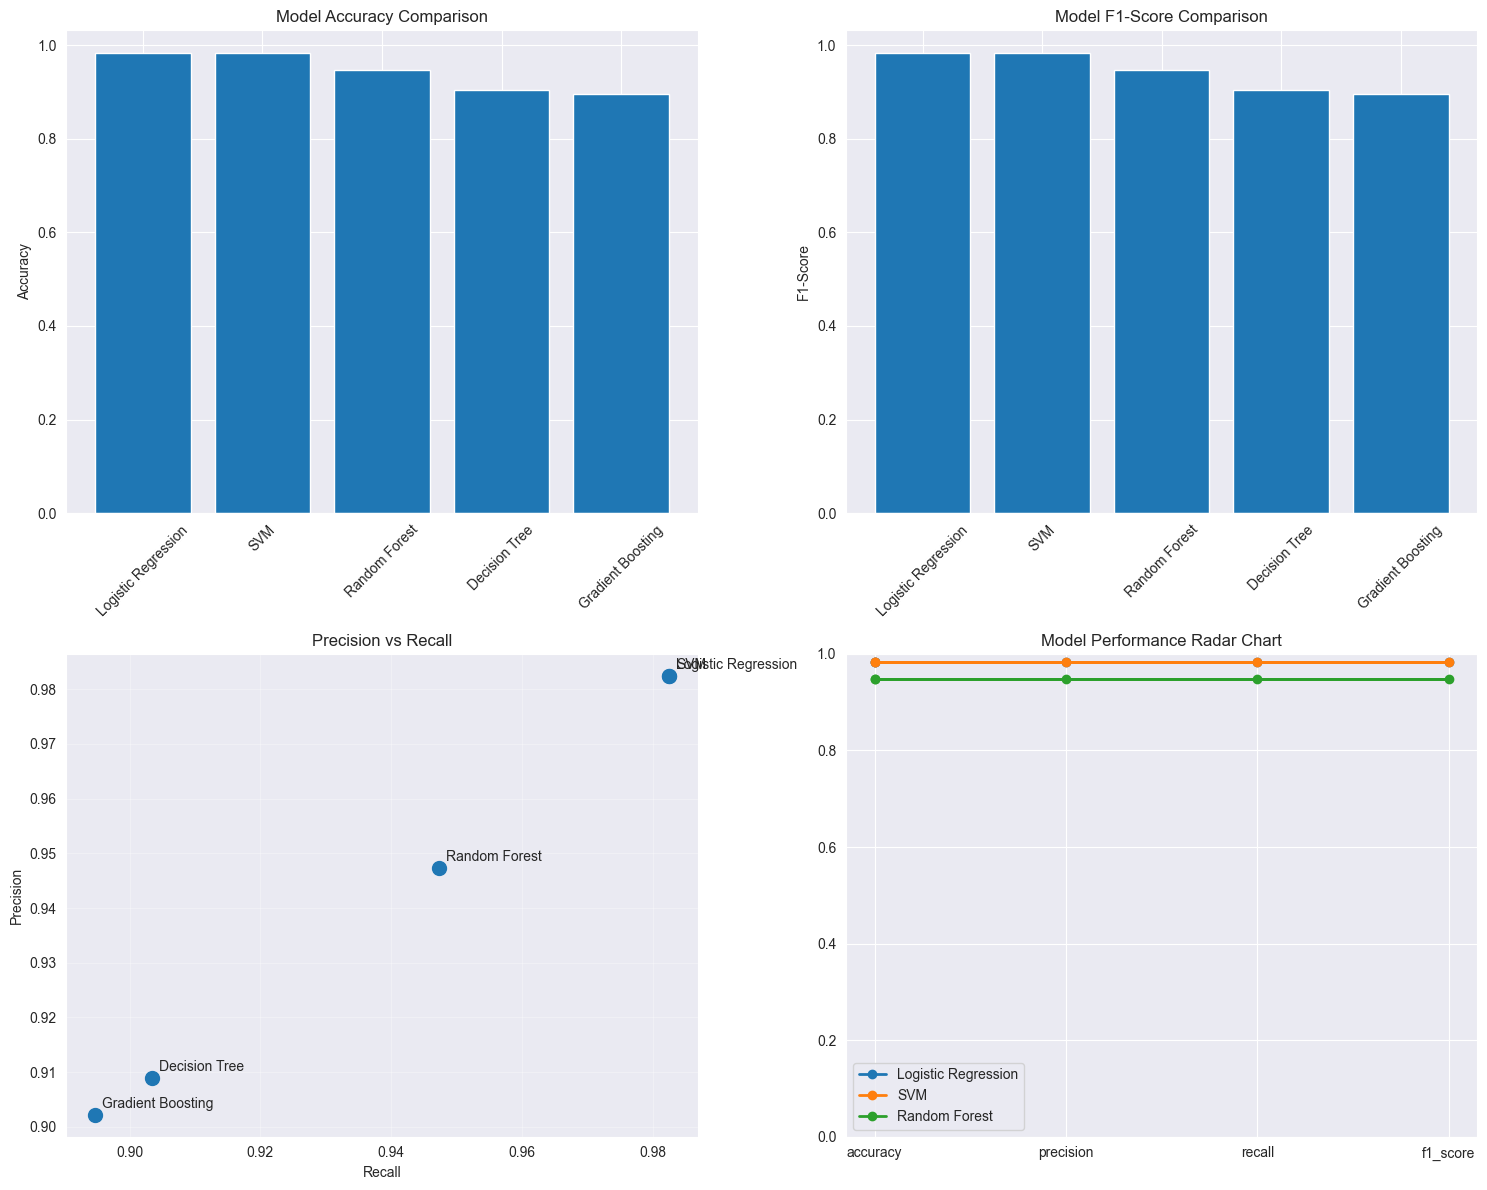

In [7]:
# Create visualizations for model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Accuracy comparison
axes[0, 0].bar(comparison_df.index, comparison_df['accuracy'])
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. F1-Score comparison
axes[0, 1].bar(comparison_df.index, comparison_df['f1_score'])
axes[0, 1].set_title('Model F1-Score Comparison')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Precision vs Recall
axes[1, 0].scatter(comparison_df['recall'], comparison_df['precision'], s=100)
for i, model in enumerate(comparison_df.index):
    axes[1, 0].annotate(model,
                       (comparison_df['recall'].iloc[i], comparison_df['precision'].iloc[i]),
                       xytext=(5, 5), textcoords='offset points')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision vs Recall')
axes[1, 0].grid(True, alpha=0.3)

# 4. Multiple metrics radar chart
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
metrics_df = comparison_df[metrics_to_plot]

ax = axes[1, 1]
angles = np.linspace(0, 2*np.pi, len(metrics_to_plot), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

for idx, model in enumerate(metrics_df.index[:3]):  # Plot top 3 models
    values = metrics_df.loc[model].values
    values = np.concatenate((values, [values[0]]))
    ax.plot(angles, values, 'o-', linewidth=2, label=model)
    ax.fill(angles, values, alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics_to_plot)
ax.set_ylim(0, 1)
ax.set_title('Model Performance Radar Chart')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

## Best Model Analysis

In [8]:
# Get the best performing model
best_model_name = comparison_df.index[0]
best_model = trained_models[best_model_name]

print(f"🏆 Best Model: {best_model_name}")
print(f"   Accuracy: {comparison_df.loc[best_model_name, 'accuracy']:.4f}")
print(f"   F1-Score: {comparison_df.loc[best_model_name, 'f1_score']:.4f}")

# Detailed evaluation of best model
evaluator = ClassificationEvaluator(model_name=best_model_name)
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

# Print comprehensive evaluation
print_evaluation_summary(
    y_test, y_pred, y_pred_proba,
    model_name=best_model_name,
    class_names=['Malignant', 'Benign']
)

🏆 Best Model: Logistic Regression
   Accuracy: 0.9825
   F1-Score: 0.9825

Evaluation Summary: Logistic Regression

Overall Metrics:
----------------------------------------
  accuracy            : 0.9825
  precision           : 0.9825
  recall              : 0.9825
  f1_score            : 0.9825
  matthews_corrcoef   : 0.9623
  cohen_kappa         : 0.9623
  roc_auc             : 0.9954
  average_precision   : 0.9971
  log_loss            : 0.0777

Classification Report:
----------------------------------------
              precision    recall  f1-score   support

   Malignant       0.98      0.98      0.98        42
      Benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114


Confusion Matrix:
----------------------------------------
[[41  1]
 [ 1 71]]




## Visualization: Confusion Metrices

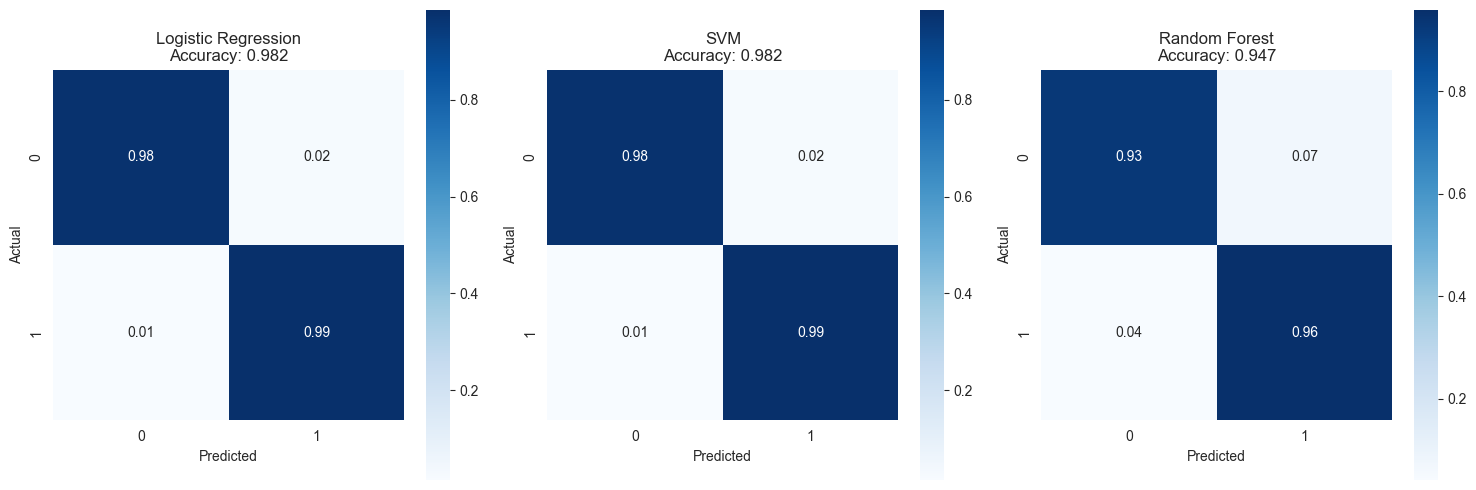

In [9]:
# Plot confusion matrices for top 3 models
top_3_models = comparison_df.head(3).index

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, model_name in enumerate(top_3_models):
    model = trained_models[model_name]
    evaluator = ClassificationEvaluator(model_name=model_name)

    y_pred = model.predict(X_test)

    # Plot confusion matrix
    ax = axes[idx]
    cm = evaluator.compute_confusion_matrix(y_test, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', square=True, ax=ax)
    ax.set_title(f'{model_name}\nAccuracy: {comparison_df.loc[model_name, "accuracy"]:.3f}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

## ROC Curves Comparison

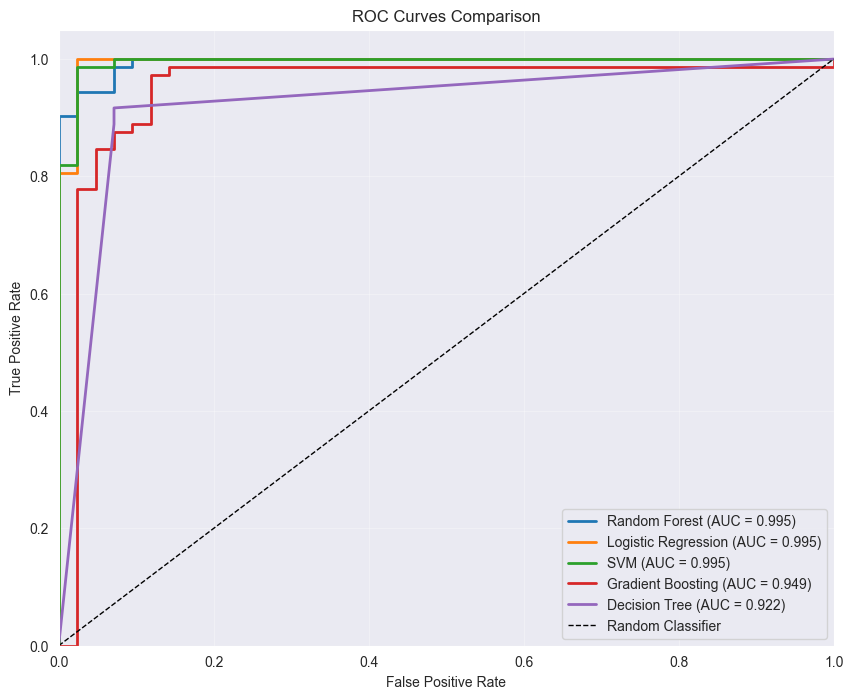

In [10]:
# Plot ROC curves for all models (binary classification)
plt.figure(figsize=(10, 8))

for model_name, model in trained_models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get positive class probabilities

    from sklearn.metrics import roc_curve, auc
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

## Feature Importance Analysis (for tree-based models)

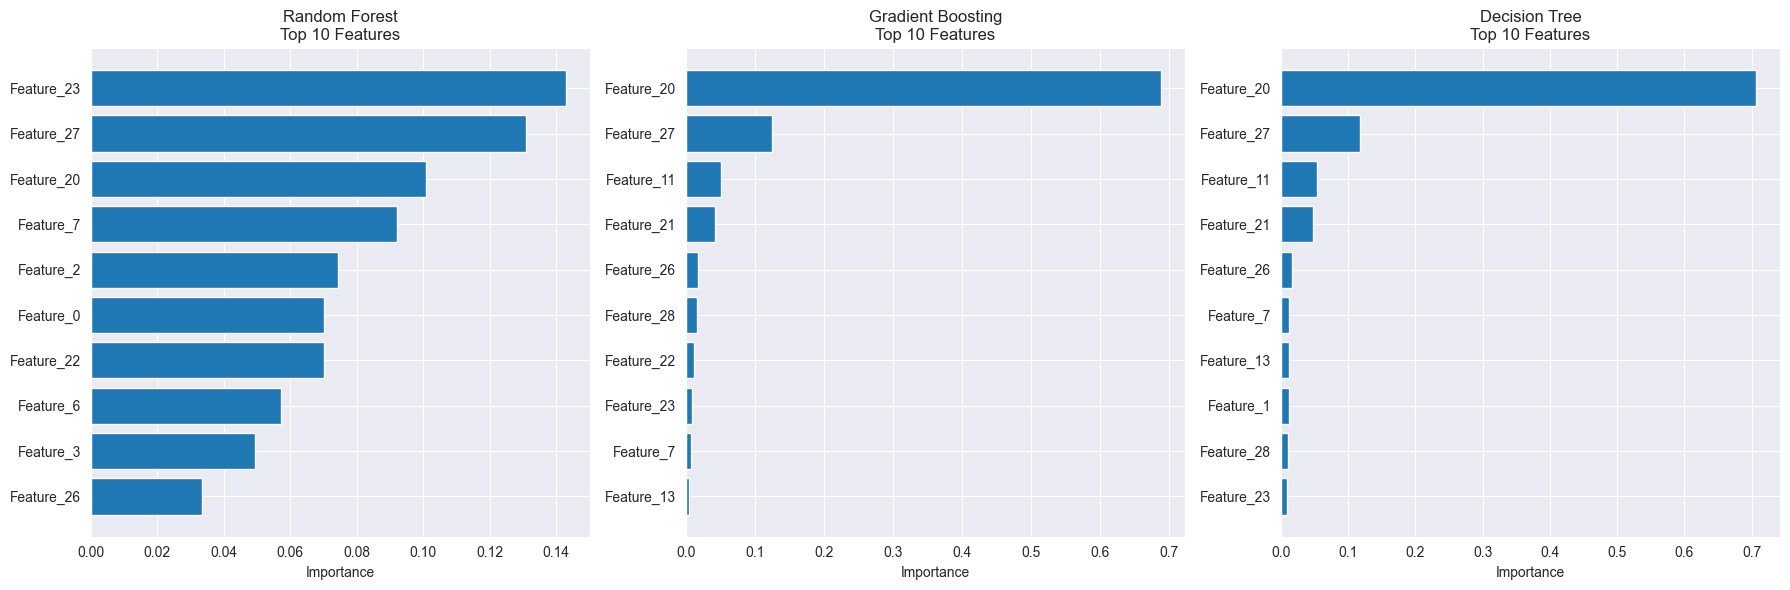

In [11]:
# Analyze feature importance for tree-based models
tree_based_models = ['Random Forest', 'Gradient Boosting', 'Decision Tree']

fig, axes = plt.subplots(1, len(tree_based_models), figsize=(18, 6))

for idx, model_name in enumerate(tree_based_models):
    if model_name in trained_models:
        model = trained_models[model_name]

        if hasattr(model, 'feature_importances_'):
            feature_names = [f'Feature_{i}' for i in range(len(model.feature_importances_))]
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=True).tail(10)

            axes[idx].barh(importance_df['feature'], importance_df['importance'])
            axes[idx].set_title(f'{model_name}\nTop 10 Features')
            axes[idx].set_xlabel('Importance')

plt.tight_layout()
plt.show()

## Model Performance Summary

In [12]:
# Create final summary table
summary_data = []

for model_name in comparison_df.index:
    cv_result = cv_results[model_name]
    test_result = comparison_df.loc[model_name]

    summary_data.append({
        'Model': model_name,
        'CV_Accuracy_Mean': cv_result['mean_score'],
        'CV_Accuracy_Std': cv_result['std_score'],
        'Test_Accuracy': test_result['accuracy'],
        'Test_F1_Score': test_result['f1_score'],
        'Test_Precision': test_result['precision'],
        'Test_Recall': test_result['recall']
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(4)

print("📊 Final Model Performance Summary:")
print("=" * 100)
print(summary_df.to_string(index=False))

# Highlight the best model
best_model_idx = summary_df['Test_F1_Score'].idxmax()
print(f"\n🏆 Recommended Model: {summary_df.loc[best_model_idx, 'Model']}")
print(f"   - Cross-validation accuracy: {summary_df.loc[best_model_idx, 'CV_Accuracy_Mean']:.4f} (±{summary_df.loc[best_model_idx, 'CV_Accuracy_Std']:.4f})")
print(f"   - Test accuracy: {summary_df.loc[best_model_idx, 'Test_Accuracy']:.4f}")
print(f"   - Test F1-score: {summary_df.loc[best_model_idx, 'Test_F1_Score']:.4f}")

📊 Final Model Performance Summary:
              Model  CV_Accuracy_Mean  CV_Accuracy_Std  Test_Accuracy  Test_F1_Score  Test_Precision  Test_Recall
Logistic Regression            0.9802           0.0128         0.9825         0.9825          0.9825       0.9825
                SVM            0.9714           0.0179         0.9825         0.9825          0.9825       0.9825
      Random Forest            0.9538           0.0254         0.9474         0.9474          0.9474       0.9474
      Decision Tree            0.9253           0.0128         0.9035         0.9045          0.9090       0.9035
  Gradient Boosting            0.9231           0.0139         0.8947         0.8960          0.9022       0.8947

🏆 Recommended Model: Logistic Regression
   - Cross-validation accuracy: 0.9802 (±0.0128)
   - Test accuracy: 0.9825
   - Test F1-score: 0.9825
